# Генерация данных #

### Загрузка пакетов ###

In [2]:
#обработка музыки
import librosa

# загрузка mp3 файлов
import audioread.ffdec  # Use ffmpeg decoder
import ffmpeg

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

#файлы в директории
from glob import glob

#воспроизведение музыки
from IPython.display import Audio

#сохранение музыки
import soundfile as sf
import json
import csv
import os

from PIL import Image

In [8]:
#класс искажения звука
class MusicEffectGen:
    def __init__(self, noise_types=["change_volume_sin"], t = 7.5, sr = 22050):
        """
        Инициализация объекта класса MusicEffectGen
        
        Параметры:
            noise_type (str) - тип звукового эффекта
        
        Возвращает:
            None
            
        Примечание:
            self.noise_func - функция классса MusicEffectGen, изменяющая звуковые ряды
        """
        self.t = t
        self.sr = sr
        self.sample_len = sample_len = librosa.time_to_samples(self.t, sr = self.sr)
        
        self.noise_funcs = {
           "change_volume_c": self.change_volume_c,
            "change_volume_sin": self.change_volume_sin,
            "change_volume_fading": self.change_volume_fading,
            "change_volume_increase": self.change_volume_increase,
            "add_some_noise": self.add_some_noise
        }
        
        
        self.noise_func = None
        self.samples = None
        self.noised_samples = None
        self.noises = None
        
        self.chose_noise_func(noise_types)
        self.load_noises()
        
        
    def chose_noise_func(self, noise_types):
        """
        Изменяет тип шума на noise_type
        
        Параметры:
            noise_type (str) - тип звукового эффекта
        
        Возвращает:
            None
            
        Примечание:
        """
        if noise_types == 'all':
            self.noise_func = list(self.noise_funcs.values())
        else:
            self.noise_func = [self.noise_funcs[noise_type] for noise_type in noise_types]
    
    
    def change_volume_c(self, index, volume_level=0.5):
        """
        Изменение громкости звукового ряда в соответствии с постоянным коэффициентом volume_level
        
        Параметры:
            index (int) - номер сэмпла для данного эффекта
            volume_level (number) - от 0 до inf (но не стоит). уровень громкости
        
        Возвращает:
            noised_samples (np.ndarray) - зашумленные нарезанные музыкальные фрагменты
            
        Примечание:
        """
        self.noised_samples[index] = self.noised_samples[index] * volume_level
        
        
    def change_volume_sin(self, index, volume_level=20):
        """
        Изменение громкости звукового ряда в соответствии со значениями функции синуса,
            взятыми с равным шагом из интервала (-volume_level / 2, volume_level / 2)
        
        Параметры:
            index (int) - номер сэмпла для данного эффекта
            volume_level (number) - от 0 до inf (но не стоит). уровень громкости
        
        Возвращает:
            noised_samples (np.ndarray) - зашумленные нарезанные музыкальные фрагменты
            
        Примечание:
            Параметр volume_level влияет на частоту колебаний громкости звука. При volume_level=20
                и длине муз. фрагментов 7.5 сек примерно 3 периода затихания-нарастания громкости
        """
        self.noised_samples[index] = self.noised_samples[index] *\
            np.array([(np.sin(x) + 1)*0.5 for x in \
                      np.arange(-volume_level / 2, volume_level / 2, volume_level / self.sample_len)])
    
    
    def change_volume_fading(self, index):
        """
        Затихание громкости звукового ряда от начальной громности до 0
        
        Параметры:
            index (int) - номер сэмпла для данного эффекта
        
        Возвращает:
            None
            
        Примечание:
        """
        self.noised_samples[index] = self.noised_samples[index] * np.arange(1, 0, -1 / self.sample_len)
    
    
    def change_volume_increase(self, index):
        """
        Нарастание громкости звукового ряда от 0 до начальной громности
        
        Параметры:
            index (int) - номер сэмпла для данного эффекта
        
        Возвращает:
            None
            
        Примечание:
        """
        self.noised_samples[index] = self.noised_samples[index] * np.arange(0, 1, 1 / self.sample_len)
    
    
    def add_some_noise(self, index, volume_level=0.5):
        """
        Накладывает на элемент noised samples шум из заранее загруженных с громкость volume level
        
        Параметры:
            index - индекс сэмпла для изменения
            volume_level (number) - от 0 до inf (но не стоит). уровень громкости
            
        Возвращает:
            None
            
        Примечание:
        """
        noised_sample = self.noised_samples[index]
        #для подгонки длины
        n = len(noised_sample)
        
        #выбор случайного шума из загруженных
        noise = np.random.choice(self.noises)

        noised_sample = noise[:n] * volume_level + noised_sample
        self.noised_samples[index] = noised_sample
    
    def load_noises(self, noises_dir="./noises_samples"):
        """
        Загружает возможные шумовые файлы в класс. Проходит по всем шумам, закливает их, 
        если они короче 7.5 секунд, сохраняет.
        
        Параметры:
            noises_dir - директория с шумами
        
        Возвращает:
            None
        
        Примечание:
        
        """
        noises_names = glob(noises_dir+ "\*.mp3")
        self.noises = []
        
        
        for noise_name in noises_names:
            _y, _sr = librosa.load(audioread.ffdec.FFmpegAudioFile(noise_name))
            #_y = np.repeat(_y, np.ceil(self.sample_len / len(_y)))
            _y = np.array([_y for i in range(int(np.ceil(self.sample_len / len(_y))))]).flatten()
            self.noises.append(_y)
            
    def load_samples(self, samples):
        """
        Загружает сэмплы в класс.
        
        Параметры:
            samples - сэмлы
        
        Возвращает:
            None
        
        Примечание:
        
        """
        self.samples = samples
        
    def generate_noised_samples(self):
        """
        Загружает сэмплы в класс.
        
        Параметры:
            None
        
        Возвращает:
            None
        
        Примечание:
        
        """
        self.noised_samples = self.samples
        
    def repeat_noised_samples(self, number):
        """
        Загружает сэмплы в класс.
        
        Параметры:
            None
        
        Возвращает:
            None
        
        Примечание:
        
        """
        self.noised_samples = np.concatenate([self.noised_samples for i in range(number)])
    
    def add_random_noises(self, samples, repeat_number = 3, num_of_effects_lambda = 0.4):
        self.load_samples(samples)
        self.generate_noised_samples()
        self.repeat_noised_samples(repeat_number)
        
        for i in range(len(self.noised_samples)):
            func = np.random.choice(self.noise_func)
            for j in range(int(np.random.poisson(lam = num_of_effects_lambda)+1)):
                func(i)
        return self.noised_samples

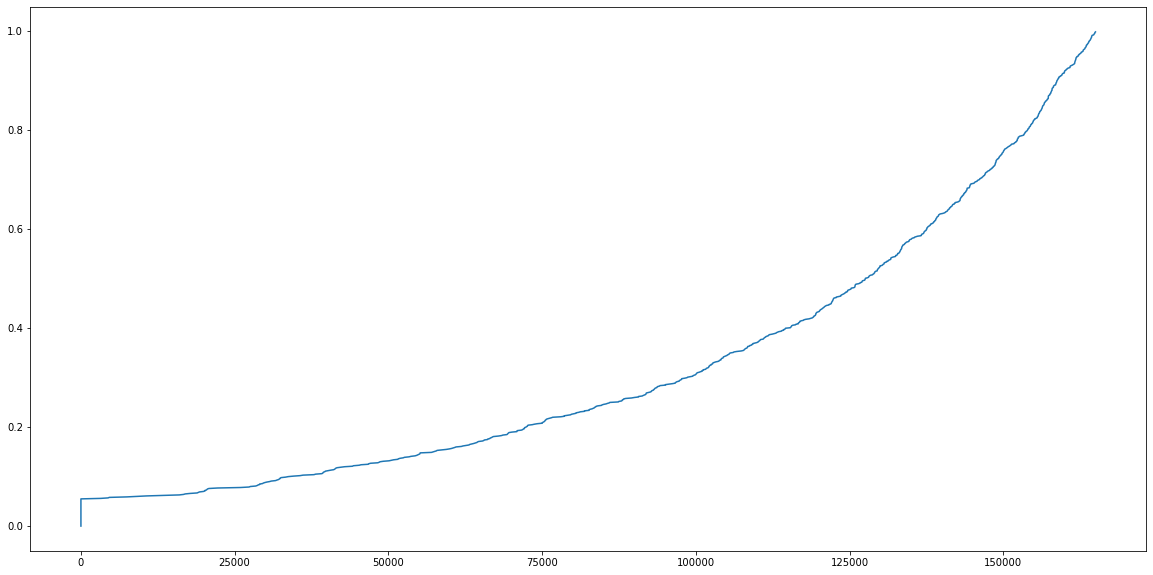

In [8]:
sample_length = librosa.time_to_samples(7.5, sr = 22000)
x = np.sort([max(0,sample_length-np.ceil(np.random.exponential() / 3 * sample_length)) for i in range(1000)])+1
y = np.arange(0,1, 0.001)
plt.plot(x, y)

In [6]:
np.random.seed(seed = 1)
aboba = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
sample_length = 3
i = 0
samples = []
while i < len(aboba) - sample_length:
    
    samples.append(aboba[i:i+sample_length])
    add = int(1 + max(0,sample_length-np.ceil(np.random.exponential() / 3 * sample_length)))
    i += add
    
    
samples.append(aboba[-sample_length:])
samples

[array([1, 2, 3]),
 array([4, 5, 6]),
 array([6, 7, 8]),
 array([ 9, 10, 11]),
 array([12, 13, 14])]

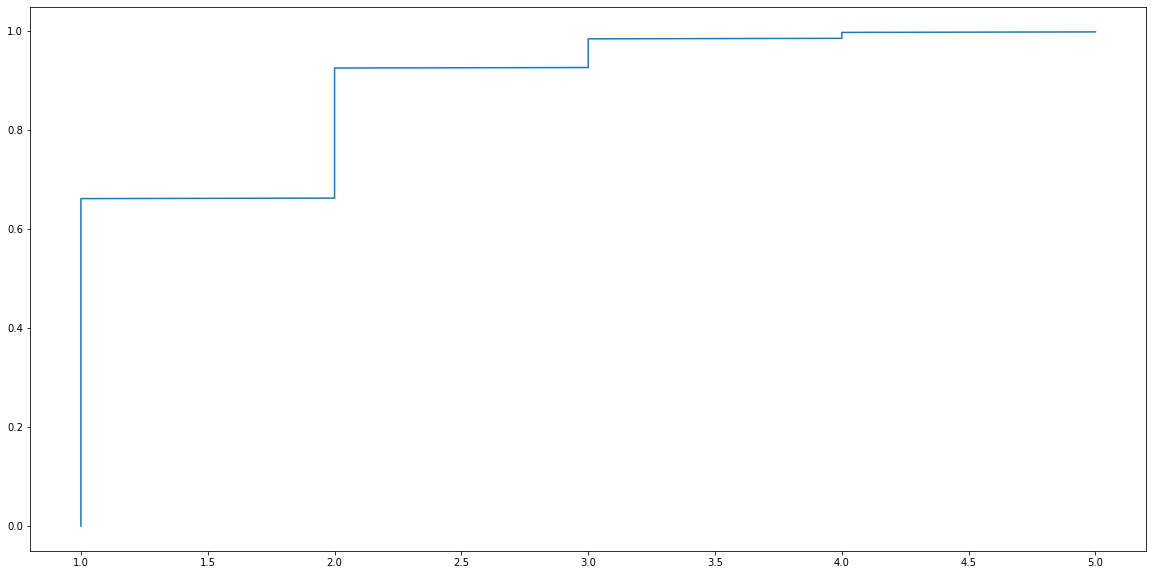

In [11]:


x = np.sort([np.random.poisson(lam = 0.39)+1 for i in range(1000)])
y = np.arange(0,1, 0.001)
plt.plot(x, y)

In [25]:
#класс генератора данных 
class DataGenerator:
    def __init__(self, audio_path=None):
        """
        Инициализация объекта класса DataGenerator
        
        Параметры:
            audio_path (str) - путь к аудиофайлу
            
        Возвращает:
            None
            
        Примечание:
            self.path (str) - путь к файлу
            self.name (str) - название музыкальной композиции
            self.y (np.ndarray) - звуковой временной ряд
            self.sr (number) - частота дискретизации y
            self.samples (np.ndarray) - нарезанные музыкальные фрагменты
            self.noised_samples (np.ndarray) - зашумлённые музыкальные фрагменты
            self.sample_length (number) - длина одного фрагмента
            self.noise_func (MusicEffectGen) - объект класса MusicEffectGen, содержащий в себе различные функции шума
        """
        
        self.path = audio_path
        self.name = None
        self.y = None
        self.sr = None
        self.samples = None
        self.sample_length = None
        self.noised_samples = None
        self.noises_class = MusicEffectGen()
        
        
    def read_audio(self, audio_path):
        """
        Чтение аудиофайла, лежащего в audio_path
        
        Параметры:
            audio_path (str) - путь к аудиофайлу
            
        Возвращает:
            None
            
        Примечание:
            Инициализирует атрибуты класса:
                y (np.ndarray) - звуковой временной ряд
                sr (int > 0) - частота дискретизации y
                name (str) - название текущего файла
        """
        self.y, self.sr = librosa.load(audioread.ffdec.FFmpegAudioFile(audio_path))
        
        name_with_extension = audio_path.split('\\')[-1]
        self.name = name_with_extension.split('.')[0]
        
        
    def to_samples(self, t = 7.5):
        """
        Нарезает звуковой временной ряд self.y на дорожки длиной t секунд
        
        Параметры:
            t (number or np.ndarray) - длина нарезки аудиофрагментов
            
        Возвращает:
            None
            
        Примечание:
            Инициализирует атрибут класса:
                self.music_fragments (np.ndarray) - массив, содержащий звуковые временные
                    ряды длины t
            
            Нарезанные фрагменты не перекрывают друг друга, за исключением, может быть, последнего,
                который подгоняется под длину t
        """
        self.sample_length = librosa.time_to_samples(t, sr = self.sr)
        _music_fragments = []
        
        #нарезка
        for i in range(int(np.ceil(self.y.shape[0] / self.sample_length))):
            _music_fragments.append(self.y[i * self.sample_length: (i + 1) * self.sample_length])
            
        #приведение последнего объекта к 7.5 секундам
        _music_fragments[-1] = np.append(_music_fragments[-1], np.zeros((self.sample_length - _music_fragments[-1].shape)))
        
        self.samples = np.array(_music_fragments)
    
    def window_to_samples(self, t = 7.5, seed = None, iter_num = 2):
        """
        Нарезает звуковой временной ряд self.y на дорожки длиной t секунд
        
        Параметры:
            t (number or np.ndarray) - длина нарезки аудиофрагментов
            
        Возвращает:
            None
            
        Примечание:
            Инициализирует атрибут класса:
                self.music_fragments (np.ndarray) - массив, содержащий звуковые временные
                    ряды длины t
            
            Нарезанные фрагменты не перекрывают друг друга, за исключением, может быть, последнего,
                который подгоняется под длину t
        """
        self.sample_length = librosa.time_to_samples(t, sr = self.sr)
        np.random.seed(seed = seed)
        _music_fragments = []
        
        # несколько проходов
        for j in range(iter_num):
            #нарезка
            i = 0
            while i < self.y.shape[0] - self.sample_length:

                _music_fragments.append(self.y[i:i+self.sample_length])
                add = int(1 + max(0,self.sample_length-np.ceil(np.random.exponential() / 3 * self.sample_length)))
                i += add

            # добавление последнего объекта
            _music_fragments.append(self.y[-self.sample_length:])
        
        self.samples = np.array(_music_fragments)
        
    
    def get_samples(self):
        """
        Выгружает нарезанные фрагменты длины t
        
        Параметры:
            None
            
        Возвращает:
            self.samples (np.ndarray) - массив, содержащий звуковые временные ряды длины t
            
        Примечание:
            Использует метод to_samples
        """
        return self.samples
   

    def add_noise(self, noise_functions=["change_volume_sin"], repeat_number = 3):
        
        """
        Добавляет шум к нарезанным музыкальным фрагментам samples
            
        Параметры:
            noise_function (str) - функция, которая накладывает шум, работает от списка сэмплов
            
        Возвращает:
            None
            
        Примечание:
        """
        #выбирает нужные функции шума и запускает их
        self.noises_class.chose_noise_func(noise_functions)
        self.noised_samples = self.noises_class.add_random_noises(self.samples, repeat_number = repeat_number)
        
        
    def save_samples(self, save_dir):
        """
        Сохраняет нарезанные музыкальные фрагменты samples
            в директории save_dir
            
        Параметры:
            save_dir (str) - директория, куда сохраняются файлы
            
        Возвращает:
            None
            
        Примечание:
            Сохраненные файлы называются по следующему принципу:
                имя-исходного-файла_номер-фрагмента.wav
        """
           
        for i in range(len(self.samples)):
            filename = self.name + "_" + str(i) + ".wav"
            directory_name = save_dir + self.name + "\\"

            if not os.path.exists(directory_name):
                os.makedirs(directory_name)
            sf.write( directory_name + filename , self.samples[i], self.sr)
           
        
    def save_noised_samples(self, save_dir):
        """
        Сохраняет нарезанные музыкальные фрагменты samples с добавленным шумом в степени noise_level
            в директории save_dir
            
        Параметры:
            save_dir (str) - директория, куда сохраняются файлы
            noise_level (number) - степень шума. от 0 до 1
            
        Возвращает:
            None
            
        Примечание:
            Сохраненные файлы называются по следующему принципу:
                noised_степень-шума_имя-исходного-файла_номер-фрагмента.wav
        """
        
        for i in range(len(self.noised_samples)):
            filename = "noised_" + "_" + self.name + "_" + str(i) + ".wav"
            directory_name = save_dir + self.name + "\\"

            if not os.path.exists(directory_name):
                os.makedirs(directory_name)
            sf.write( directory_name + filename , self.noised_samples[i], self.sr)
            
    def save_noised_cens(self, save_dir = "./csv_data/"):
        """
        Перевод вектор зашумленных музыкальных файлов в вектор Chroma Energy Normalized.
        Затем сохраняет в csv файл
            
        Параметры:
            save_dir (str) - json файл, куда сохраняются данные
            
        Возвращает:
            None
            
        Примечание:
        
        """
        
        with open(save_dir + self.name + '.csv', 'w', newline='') as file:
            spamwriter = csv.writer(file)
            spamwriter.writerow([self.name, self.sr])
            for sample in self.noised_samples:
                y_harmonic, y_percussive = librosa.effects.hpss(sample)
                C = librosa.feature.chroma_cqt(y=y_harmonic, sr = self.sr)
                spamwriter.writerow(C.flatten())
    
    def save_image_cens(self, save_dir = './images/'):
        
        directory_name = save_dir + self.name + "\\"
        if not os.path.exists(directory_name):
            os.makedirs(directory_name)
            
        for i, sample in enumerate(self.noised_samples):
            y_harmonic, y_percussive = librosa.effects.hpss(sample)
            C = librosa.feature.chroma_cqt(y=y_harmonic, sr = self.sr)
            formatted = (C * 255 / np.max(C)).astype('uint8')
            img = Image.fromarray(formatted)
            img.save(directory_name + self.name + "_" + str(i) + ".jpeg")
    
    def save_image_spec(self, save_dir = './images/'):
        
        directory_name = save_dir + self.name + "\\"
        if not os.path.exists(directory_name):
            os.makedirs(directory_name)
            
        for i, sample in enumerate(self.noised_samples):
            S = librosa.feature.melspectrogram(y = sample, sr = self.sr, n_mels = 128)
            #S = librosa.stft(sample)
            #S = librosa.amplitude_to_db(S)
            formatted = np.array(S).astype('uint8')
            img = Image.fromarray(formatted)
            img.save(directory_name + self.name + "_" + str(i) + ".jpeg")
        
            
    def save_to_json(self, save_dir):
        """
        Сохраняет нарезанные музыкальные фрагменты samples
            в json файле save_dir
            
        Параметры:
            save_dir (str) - json файл, куда сохраняются данные
            
        Возвращает:
            None
            
        Примечание:
            Сохраненные файлы называются по следующему принципу:
                [{
                    init_dict:
                        {
                        name: str
                        sr: int > 0
                        noised: bool
                        noise_level: number
                        },
                    samples: list of lists of numbers
                 } , ...]
        """
        with open(save_dir + self.name + '.json', "w") as file:
            _data = {'init_dict': {'name': self.name, 'sr': self.sr}, 
                          'samples': [list(_) for _ in self.samples]}
            file.seek(0)
            json.dump(_data, file)
            
    def save_noised_to_json(self, save_dir):
        """
        Сохраняет нарезанные музыкальные фрагменты samples
            в json файле save_dir
            
        Параметры:
            save_dir (str) - json файл, куда сохраняются данные
            
        Возвращает:
            None
            
        Примечание:
            Сохраненные файлы называются по следующему принципу:
                [{
                    init_dict:
                        {
                        name: str
                        sr: int > 0
                        noised: bool
                        noise_level: number
                        },
                    samples: list of lists of numbers
                 } , ...]
        """
        with open(save_dir + self.name + '.json', "w") as file:
            _data = {'init_dict': {'name': self.name, 'sr': self.sr}, 
                          'samples': [list(_) for _ in self.noised_samples]}
            file.seek(0)
            json.dump(_data, file)
    
    def save_to_csv(self, save_dir):
        """
        Сохраняет нарезанные музыкальные фрагменты csv файле
            
        Параметры:
            save_dir (str) - json файл, куда сохраняются данные
            
        Возвращает:
            None
            
        Примечание:
        
        """
        with open(save_dir + self.name + '.csv', 'w', newline='') as file:
            spamwriter = csv.writer(file)
            spamwriter.writerow([self.name, self.sr])
            for sample in self.noised_samples:
                spamwriter.writerow(sample)
    
    def generate_noised_data(self, audio_path, save_dir, _type = 'sample', noise_functions = 'all'):
        """
        Генерирует зашумлённое аудио по пути audio_path,
        сохраняет в директорию по пути save_dir
        
            
        Параметры:
            audio_path (str) - путь до музыкального файла
            save_dir (str) - директория сохранения
            _type(str) - csv или sample, показывает тип сохранения данных
            
        Возвращает:
            None
            
        Примечание:
       
        """
        self.read_audio(audio_path)
        self.window_to_samples(seed = 42, iter_num = 3)
        self.add_noise(noise_functions=noise_functions, repeat_number = 2)
        if _type == 'sample':
            self.save_noised_samples(save_dir)
        elif _type == 'csv':
            self.save_noised_cens(save_dir)
        elif _type == 'cens':
            self.save_image_cens(save_dir)
        elif _type == 'spec':
            self.save_image_spec(save_dir)

In [26]:
def generate_data(dataGen, audio_paths, save_dir, _type = 'csv'):
    musicfiles = []
    for path in audio_paths:
        musicfiles.extend(glob(path+ "\**\*.flac", recursive = True))
        musicfiles.extend(glob(path+ "\**\*.mp3", recursive = True))
    for song in musicfiles:
        dataGen.generate_noised_data(song, save_dir, _type, noise_functions = 'all')
        
def generate_samples(dataGen, audio_path, save_dir):
    musicfiles = glob(audio_path+ "\*.mp3")
    for song in musicfiles:
        dataGen.generate_samples_data(song, save_dir)

In [27]:
ex_dg = DataGenerator()

In [28]:
audio_paths = ['.\\music', r"C:\Users\Shulnyaev\Music"]
noised_save_dir = '.\\wav_noised_data\\'
save_dir = '.\\wav_data\\'
#save_dir_csv ="./csv_data/"
save_dir_image_cens = r"D:\data\zamzam\\cens\\"
save_dir_image_spec = r"D:\data\zamzam\\spec\\"
noise_dir = '.\\noises_samples'
generate_data(ex_dg, audio_paths, save_dir_image_cens, _type = 'cens')

<ipython-input-8-aee2a2970037>:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noise = np.random.choice(self.noises)


In [ ]:
audio_path = r"C:\Users\Shulnyaev\Music"
dirrr = glob(audio_path+ "\**\*.flac", recursive = True)
y, sr = librosa.load(dirrr[0])